# BONUS: Temperature Analysis I

Is there a meaningful difference in temperature, for example, between June and December?

In [1]:
# Setup matplotlib libraries and graph style
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Bring in library packages
import pandas as pd
import numpy as np
import datetime as dt

In [3]:
# Bring in SQLAlchemy library
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float

In [8]:
# Use SQL Alchemy to create an engine and connect with sqlite database
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [9]:
# Designate base to reflect the sqlite database into a new model 
Base = automap_base()

# Tell python to use base to reflect the tables
Base.prepare(engine, reflect = True)

In [10]:
# Look at all the classes in the sqlite file
Base.classes.keys()

['measurement', 'station']

In [11]:
# Create and save each class to a table reference. Reflect the sqlite data.
Measurement = Base.classes.measurement
Station = Base.classes.station



In [12]:
# Link Python to the database by creating an SQLAlchemy session
session = Session(bind=engine)

Use Pandas:
1. Convert 'date' column from string to datetime
2. Set datetime to index
3. Drop the 'date' column 

In [ ]:
session.query(Measurement.date, pd.to_datetime(df['date'], format(%Y-%m-%d))
              
df.set_index('date', inplace=False)



In [23]:
from sqlalchemy import extract
june_temps = session.query(Measurement).filter(extract('month', Measurement.date) == 6)
june_temp_list = [temp.tobs for temp in june_temps]
print(np.mean(june_temp_list))



74.94411764705882


In [24]:
dec_temps = session.query(Measurement).filter(extract('month', Measurement.date) == 12)
dec_temp_list = [temp.tobs for temp in dec_temps]
print(np.mean(dec_temp_list))

71.04152933421226


### Use t-test to compare the difference in means
Would you use paired or unpaired t-test? and Why?
ANS. I would use a paired t-test because we are comparing the temperatures of the same stations. Paired t-tests are best for observations on the same group, item or source over time, which is the case of this data.

In [25]:
from scipy import stats
stats.ttest_ind(june_temp_list, dec_temp_list)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

# BONUS: Temperature Analysis II
Look at historical data for start date: August 1 and end date: August 7

The function 'calc_temps' will accept start date and end date and will return the minimum, average, and maximum temperatures for that range.


In [39]:
def calc_temps(start_date, end_date):
    '''TMIN, TAVG, and TMAX for a list of dates
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, TMAX'''
        
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))\
                    .filter(Measurement.date >= start_date)\
                    .filter(Measurement.date <= end_date).all()

print(calc_temps('2017-08-01', '2017-08-07'))

[(72.0, 79.25, 83.0)]


In [37]:
# Use your previous function 'calc_temps' to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates

import datetime as dt
prev_year_start = dt.date(2017, 8, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 8, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)


72.0 77.79545454545455 83.0


<ipython-input-40-c0183bcb0563>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


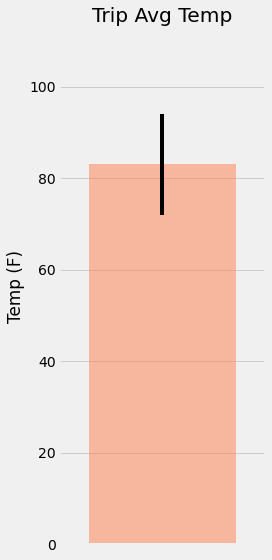

In [40]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color="coral", align='center')
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.tight_layout()
fig.show()

In [41]:
# Calculate the total amount of rainfall per weather station for your trip
# Sort this in descending order by precipitation amount and list the station
start_date = '2012-08-01'
end_date = '2012-08-07'

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).\
    order_by(func.sum(Measurement.prcp).\
    desc()).all()

print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.16), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.26), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.24), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.22), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.07), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.01), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]


# BONUS:  Daily Rainfall Average

In [42]:
# Calculate the daily normals for your trip
# push each tuple of calculations into a list called 'normals'

#set the start and end date of the trip
trip_start = '2017-08-01'
trip_end = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Strip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')


# Loop through the list of the %m-%d strings and calculate the normals for each
normals =[]
for date in trip_month_day:
    normals.append(*daily_normals(date))
normals





[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [43]:
# Create a query that will calculate the daily normals
# (i.e., the averages for tmin, tavg, and tmax for all historical data matching)

def daily_normals(date):
    '''Daily Normals
    
    
    Args:
        date (str): A date string in the format '%m-d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    '''
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

daily_normals("08-01")

[(67.0, 75.54, 83.0)]

In [44]:
# Load the previous query results into a Pandas Dataframe
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'], inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0


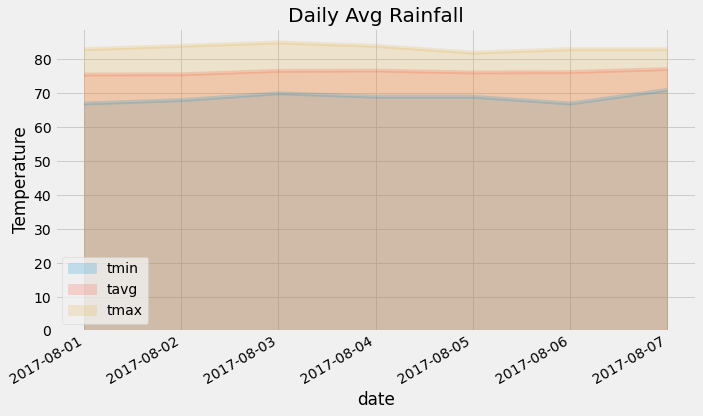

In [50]:
# Plot the daily normals as an area plot with 'stacked=False'
df.plot(kind='area', figsize=(10,6), stacked=False, x_compat=True, alpha=.2)
plt.ylabel("Temperature")
plt.title("Daily Avg Rainfall")
plt.tight_layout()
